<a href="https://colab.research.google.com/github/BrMrtn/GoogleColab/blob/main/K%C3%A9pfeldolgoz%C3%A1s/khf6_L%C5%91lap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap1_1.bmp
!wget https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap1_2.bmp
!wget https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap2_1.bmp
!wget https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap2_2.bmp

--2024-12-05 22:13:45--  https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap1_1.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5070054 (4.8M) [image/bmp]
Saving to: ‘lolap1_1.bmp.26’

lolap1_1.bmp.26     100%[===================>]   4.83M  --.-KB/s    in 0.09s   

2024-12-05 22:13:45 (52.5 MB/s) - ‘lolap1_1.bmp.26’ saved [5070054/5070054]

--2024-12-05 22:13:45--  https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap1_2.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5070054 (4.8M

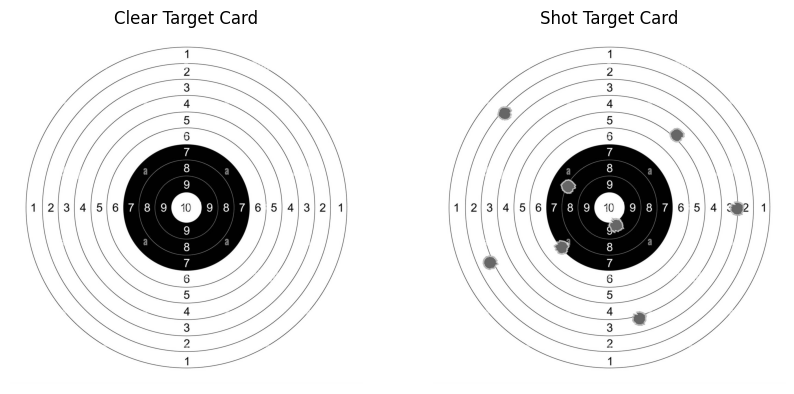

In [3]:
target_card = cv2.imread('lolap1_1.bmp')
target_card_shot = cv2.imread('lolap1_2.bmp')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(target_card, cv2.COLOR_BGR2RGB))
axs[0].set_title('Clear Target Card')
axs[1].imshow(cv2.cvtColor(target_card_shot, cv2.COLOR_BGR2RGB))
axs[1].set_title('Shot Target Card')
axs[0].axis('off'); axs[1].axis('off');

In [4]:
# Hough-transzformáció használatához szürkeárnyalator kép kell
target_card = cv2.cvtColor(target_card, cv2.COLOR_BGR2GRAY)
target_card_shot = cv2.cvtColor(target_card_shot, cv2.COLOR_BGR2GRAY)

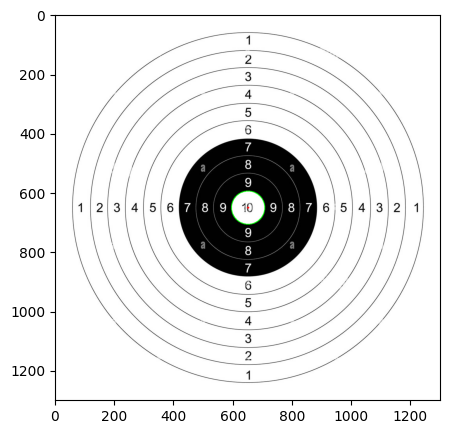

In [5]:
# Alapkörök megtalálása a lövések nélküli képen

width = 56 # A gyűrű egyes csíkjainak szélessége (a 10-es kör sugara).
# közép: 650, 650


base_circles = []

# 10-es kör megtalálása
found_circles = cv2.HoughCircles(target_card, cv2.HOUGH_GRADIENT, 1, 1000, param1=200, param2=10, minRadius=56-10, maxRadius=56+10) # image, method, 1 (accumulator res = img res), minDist,
found_circles = np.uint16(np.around(found_circles)) # típuskonverzió (ne legyen pl. 2.4-edik pixel)
circle10 = found_circles[0, 0]
base_circles.append(circle10)


target_card = cv2.cvtColor(target_card, cv2.COLOR_GRAY2BGR)
for i in found_circles[0, :]:
  cv2.circle(target_card, (i[0], i[1]), i[2], (0, 255, 0), 2)
  cv2.circle(target_card, (i[0], i[1]), 2, (0, 0, 255), 3)

# show target card
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.imshow(cv2.cvtColor(target_card, cv2.COLOR_BGR2RGB))